In [1]:
dataset_name = "exchange-2_cpc_results"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 128

In [2]:
import adclasses
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/framework/ops.py:939: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


# Preprocess dataset

In [3]:
data = pd.read_csv(path, header=0)
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)

data["timestamp"] = pd.to_datetime(data["timestamp"], 
                                   format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, 
                                                                   '1H', data))

# if you want to use a method that cannot take missing time steps
# into account, you need to fill in the missing time steps yourself
# this function also removes duplicates
print("Fill Missing Time Steps with Interpolation")
data = adclasses.fill_missing_time_steps(start_date, end_date, '1H', data, method="linear")

ad = adclasses.UnivariateAnomalyDetection(dataframe=data, 
                                          timestep="1H", 
                                          dateformat="%Y-%m-%d %H:%M:%S", 
                                          name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Start Date: ", start_date)
print("End Date: ", end_date)
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2011-07-14 13:00:01"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2011-07-01 00:00:01
End date:  2011-09-07 15:00:01
Missing time stamps: 
 DatetimeIndex(['2011-07-21 05:00:01', '2011-08-08 18:00:01',
               '2011-08-10 16:00:01', '2011-08-15 22:00:01',
               '2011-08-15 23:00:01', '2011-09-01 19:00:01',
               '2011-09-01 20:00:01', '2011-09-01 21:00:01',
               '2011-09-01 22:00:01', '2011-09-01 23:00:01',
               '2011-09-02 00:00:01', '2011-09-02 01:00:01',
               '2011-09-02 02:00:01', '2011-09-02 03:00:01',
               '2011-09-02 04:00:01', '2011-09-02 05:00:01',
               '2011-09-02 06:00:01', '2011-09-02 07:00:01',
               '2011-09-02 08:00:01', '2011-09-02 09:00:01',
               '2011-09-02 10:00:01', '2011-09-02 11:00:01',
               '2011-09-02 12:00:01', '2011-09-02 13:00:01',
               '2011-09-02 14:00:01'],
              dtype='datetime64[ns]', freq=None)
Fill Missing Time Steps with Interpolation
Duplicate records found: 
                        

# SARIMA: using own params

# trend, seasonality -> HWES

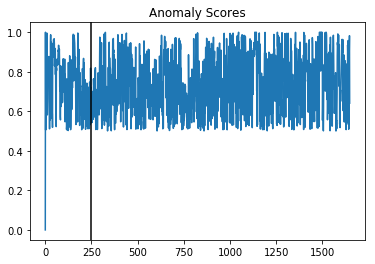

Time:  2.0414416790008545
RMSE:  0.01176056847427363


['anomaly_scores/SARIMA_guide/exchange-2_cpc_results']

In [4]:
save_path = "anomaly_scores/SARIMA_guide/" + dataset_name
output_dict = ad.hwes(gaussian_window_size=gaussian_window_size,slen=24, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
print("RMSE: ", output_dict["RMSE"])
joblib.dump(output_dict, save_path)

# SARIMA: using autoarima

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 24); AIC=-1318.788, BIC=-1290.745, Fit time=3.795 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 24); AIC=-1250.832, BIC=-1243.821, Fit time=0.227 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 24); AIC=-1335.114, BIC=-1321.092, Fit time=3.115 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 24); AIC=-1277.673, BIC=-1263.652, Fit time=2.570 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 24); AIC=-1256.164, BIC=-1245.648, Fit time=0.149 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 0, 24); AIC=-1369.388, BIC=-1351.862, Fit time=19.824 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 1, 24); AIC=-1371.585, BIC=-1350.553, Fit time=22.145 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 1, 24); AIC=-1387.753, BIC=-1370.226, Fit time=19.737 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 0, 1, 24); AIC=-1372.052, BIC=-1351.020, Fit time=16.854 seconds
Fit AR

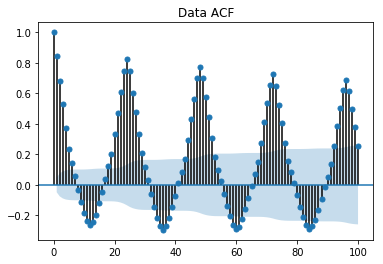

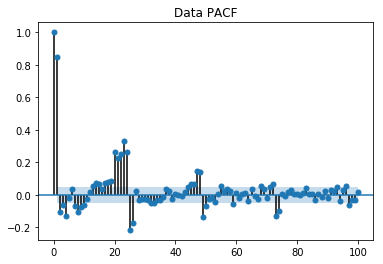

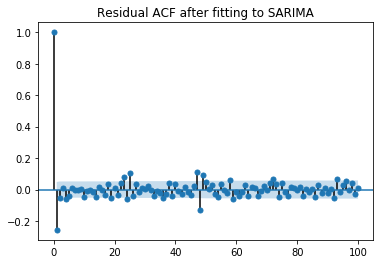

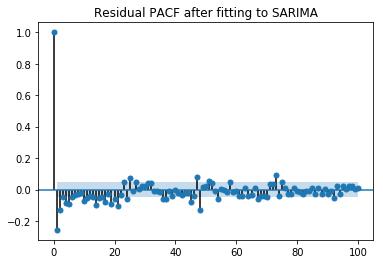

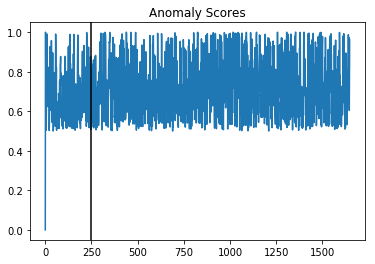

Time:  171.72163653373718
RMSE:  0.015481164710496544


['anomaly_scores/SARIMA_auto/exchange-2_cpc_results']

In [5]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name
output_dict = ad.sarima(gaussian_window_size=gaussian_window_size,
                        autoarima=True, 
                        autoarima_season=True, 
                        s = 24,
                        plot_acf=True, 
                        maxiter=3, 
                        plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
print("RMSE: ", output_dict["RMSE"])
joblib.dump(output_dict, save_path)

# Facebook Prophet

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


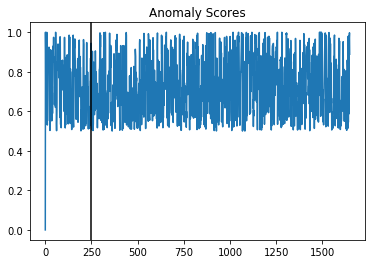

Time:  15.251557111740112
RMSE:  0.017277340059688683


['anomaly_scores/Prophet/exchange-2_cpc_results']

In [6]:
save_path = "anomaly_scores/Prophet/" + dataset_name
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size,periods=0, daily_seasonality=True, interval_width=.999, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
print("RMSE: ", output_dict["RMSE"])
joblib.dump(output_dict, save_path)

# RNN

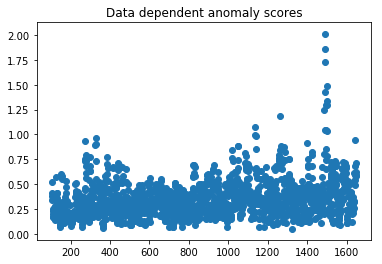

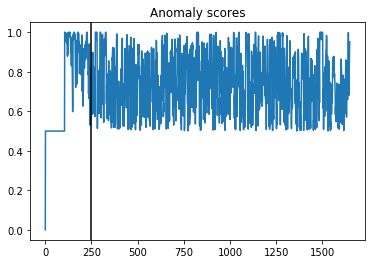

Time:  81.75513362884521


['anomaly_scores/RNN/exchange-2_cpc_results']

In [4]:
save_path = "anomaly_scores/RNN/" + dataset_name
output_dict = ad.rnn(gaussian_window_size=gaussian_window_size,n_lag=100, n_seq=5, n_test=20, n_epochs=50,
                     n_batch=1, n_neurons=40, training_index=int(.15 * ad.get_length()), plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

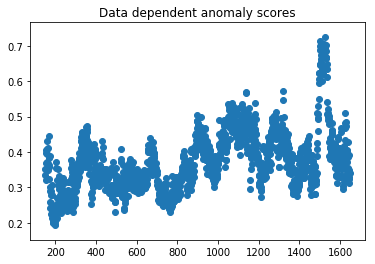

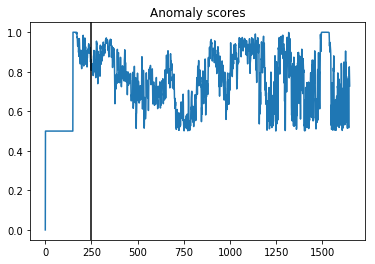

Time:  133.22403240203857


['anomaly_scores/RNN/exchange-2_cpc_results']

In [7]:
save_path = "anomaly_scores/RNN/" + dataset_name
output_dict = ad.rnn(gaussian_window_size=gaussian_window_size,n_lag=100, n_seq=50, n_test=20, n_epochs=50,
                     n_batch=1, n_neurons=40, training_index=int(.15 * ad.get_length()), plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Twitter AD

In [8]:
save_path = "anomaly_scores/Twitter/" + dataset_name
output_dict = ad.twitterad(period=24,max_anoms=2/ad.get_length(), direction='both', alpha=.001, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

R twitterad completed: True
Time:  0.3662137985229492


['anomaly_scores/Twitter/exchange-2_cpc_results']

# HTM

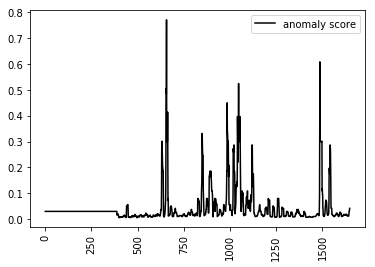

Time:  17.19


['anomaly_scores/HTM/exchange-2_cpc_results']

In [9]:
htm_results_path = "htm_studio_results/" + "htm_results_" + dataset_name + "_value.csv"
htm_results = pd.read_csv(htm_results_path, header=0)

plt.plot(htm_results["raw_anomaly_score"], color="black", label="anomaly score")
plt.legend()
plt.xticks(rotation=90)
plt.show()

anomaly_scores = np.nan_to_num(htm_results["raw_anomaly_score"].values)

save_path = "anomaly_scores/HTM/" + dataset_name
print("Time: ", "17.19")
output_dict = {"Anomaly Scores": anomaly_scores, "Time": "17.19"}
joblib.dump(output_dict, save_path)

# Donut

Trainable Parameters              (27,950 in total)
---------------------------------------------------
donut/p_x_given_z/x_mean/bias    (20,)           20
donut/p_x_given_z/x_mean/kernel  (100, 20)    2,000
donut/p_x_given_z/x_std/bias     (20,)           20
donut/p_x_given_z/x_std/kernel   (100, 20)    2,000
donut/q_z_given_x/z_mean/bias    (5,)             5
donut/q_z_given_x/z_mean/kernel  (100, 5)       500
donut/q_z_given_x/z_std/bias     (5,)             5
donut/q_z_given_x/z_std/kernel   (100, 5)       500
sequential/_0/dense/bias         (100,)         100
sequential/_0/dense/kernel       (5, 100)       500
sequential/_1/dense/bias         (100,)         100
sequential/_1/dense/kernel       (100, 100)  10,000
sequential_1/_0/dense/bias       (100,)         100
sequential_1/_0/dense/kernel     (20, 100)    2,000
sequential_1/_1/dense/bias       (100,)         100
sequential_1/_1/dense/kernel     (100, 100)  10,000

[Epoch 10/256, Step 0, ETA 0.2597s] Learning rate decreased to 

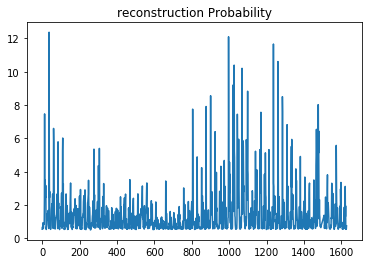

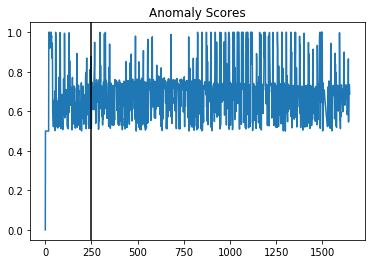

Time:  5.531100749969482


['anomaly_scores/Donut/exchange-2_cpc_results']

In [10]:
save_path = "anomaly_scores/Donut/" + dataset_name
output_dict = ad.donut(gaussian_window_size=gaussian_window_size,window_size=20, plot_reconstruction_prob=True, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# STL Resid

R stlplus completed:  no missing True


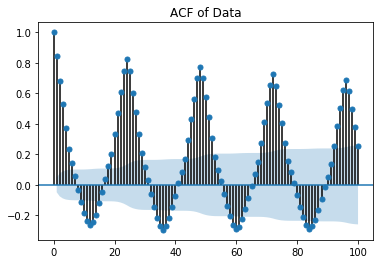

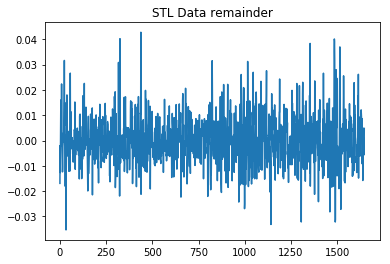

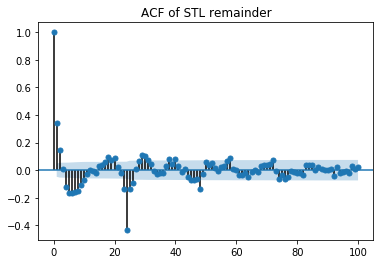

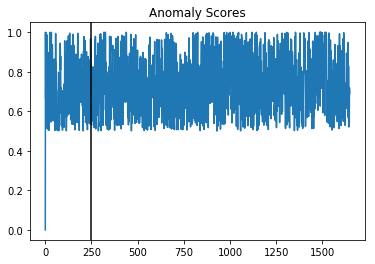

Time:  1.899789810180664


['anomaly_scores/stl/exchange-2_cpc_results']

In [12]:
save_path = "anomaly_scores/stl/" + dataset_name
output_dict = ad.stl_resid(gaussian_window_size=gaussian_window_size,n_periods=24, swindow=7, outer=1, fill_option="linear", plot_resid=True, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# windowed gaussian

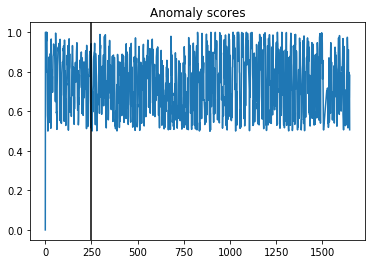

Time:  0.28597187995910645


['anomaly_scores/windowed_gaussian/exchange-2_cpc_results']

In [13]:
save_path = "anomaly_scores/windowed_gaussian/" + dataset_name
output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size,plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HOTSAX

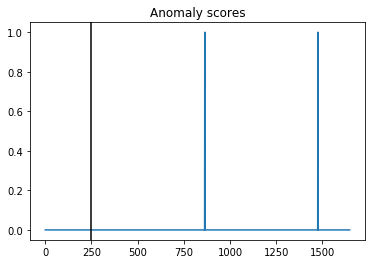

Time:  11.527150392532349


['anomaly_scores/hotsax/exchange-2_cpc_results']

In [14]:
save_path = "anomaly_scores/hotsax/" + dataset_name
output_dict = ad.hotsax(win_size=50, num_discords=2,
               a_size=3, paa_size=3, z_threshold=0.01,
               plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)